<a href="https://colab.research.google.com/github/nguyen-nghia-yokohama/nghia/blob/master/3_5_classifying_newswires_case2_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: "Classifying newswires: a multi-class classification example"
output: 
  html_notebook: 
    theme: cerulean
    highlight: textmate
---



***

This notebook contains the code samples found in Chapter 3, Section 6 of [Deep Learning with R](https://www.manning.com/books/deep-learning-with-r). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

***

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [109]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
## restart runtime after this if you encounter an error on reading reuters data.
## https://teratail.com/questions/186503
#system("pip install numpy==1.16.1")

In [0]:
library(keras)

reuters <- dataset_reuters(num_words = 10000)
c(c(train_data, train_labels), c(test_data, test_labels)) %<-% reuters

Like with the IMDB dataset, the argument `num_words = 10000` restricts the data to the 10,000 most frequently occurring words found in the data.

We have 8,982 training examples and 2,246 test examples:

In [112]:
length(train_data)

[1] 8982

In [113]:
length(test_data)

[1] 2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [114]:
train_data[[1]]

[1]    1    2    2    8   43   10  447    5   25  207  270    5 3095  111   16
[16]  369  186   90   67    7   89    5   19  102    6   19  124   15   90   67
[31]   84   22  482   26    7   48    4   49    8  864   39  209  154    6  151
[46]    6   83   11   15   22  155   11   15    7   48    9 4579 1005  504    6
[61]  258    6  272   11   15   22  134   44   11   15   16    8  197 1245   90
[76]   67   52   29  209   30   32  132    6  109   15   17   12

Here's how you can decode it back to words, in case you are curious:

In [0]:
word_index <- dataset_reuters_word_index()
reverse_word_index <- names(word_index)
names(reverse_word_index) <- word_index
decoded_newswire <- sapply(train_data[[1]], function(index) {
  # Note that our indices were offset by 3 because 0, 1, and 2
  # are reserved indices for "padding", "start of sequence", and "unknown".
  word <- if (index >= 3) reverse_word_index[[as.character(index - 3)]]
  if (!is.null(word)) word else "?"
})

In [116]:
cat(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3

The label associated with an example is an integer between 0 and 45: a topic index.

In [117]:
train_labels[[1]]

[1] 3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [0]:
vectorize_sequences <- function(sequences, dimension = 10000) {
  results <- matrix(0, nrow = length(sequences), ncol = dimension)
  for (i in 1:length(sequences))
    results[i, sequences[[i]]] <- 1
  results
}

x_train <- vectorize_sequences(train_data)
x_test <- vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1. In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [0]:
to_one_hot <- function(labels, dimension = 46) {
  results <- matrix(0, nrow = length(labels), ncol = dimension)
  for (i in 1:length(labels))
    results[i, labels[[i]] + 1] <- 1
  results
}

one_hot_train_labels <- to_one_hot(train_labels)
one_hot_test_labels <- to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [0]:
one_hot_train_labels <- to_categorical(train_labels)
one_hot_test_labels <- to_categorical(test_labels)

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the dimensionality of the output space is much larger. 

In a stack of dense layers like what we were using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [0]:
model <- keras_model_sequential() %>% 
  layer_dense(units = 32, activation = "relu", input_shape = c(10000)) %>% 
  #layer_dense(units = 64, activation = "relu") %>% 
  layer_dense(units = 46, activation = "softmax")

There are two other things you should note about this architecture:

* You end the network with a dense layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.

* The last layer uses a `softmax` activation. You saw this pattern in the MNIST example. It means the network will  output a _probability distribution_ over the 46 different output classes: that is,  for every input sample, the network will produce a 46-dimensional output vector, where `output[[i]]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.


The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [0]:
model %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [0]:
val_indices <- 1:1000

x_val <- x_train[val_indices,]
partial_x_train <- x_train[-val_indices,]

y_val <- one_hot_train_labels[val_indices,]
partial_y_train = one_hot_train_labels[-val_indices,]

Now let's train our network for 20 epochs:

In [0]:
history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 20,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
results <- model %>% evaluate(x_test, one_hot_test_labels)

In [125]:
results

$loss
[1] 0.9557007

$acc
[1] 0.7956367

Let's display its loss and accuracy curves:

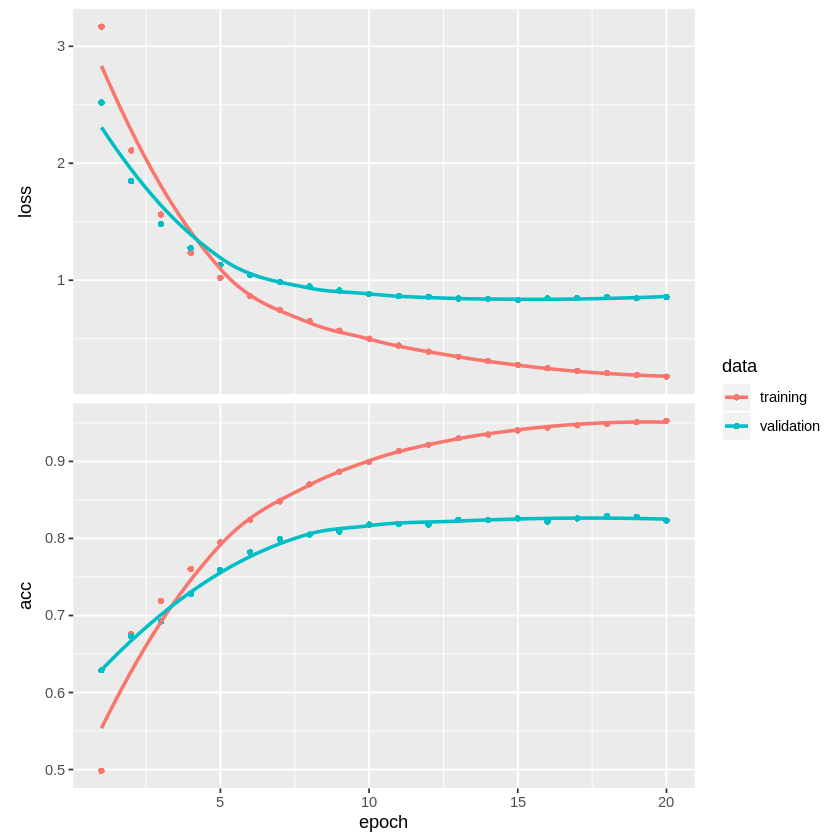

In [126]:
plot(history)